In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import numpy as np
from matplotlib import cm
from  matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from scipy.stats import norm



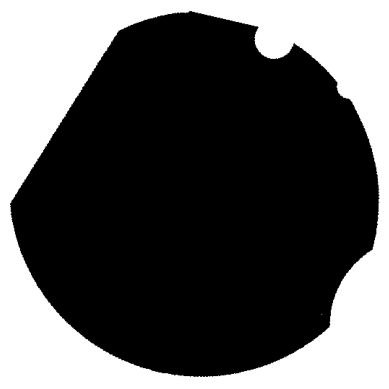

In [69]:

# load the mask image
maskim = Image.open('./img/mask.png')
maskdata = np.array(maskim, dtype='i2')

plt.figure()
plt.axis('off')
plt.imshow(maskim, cmap='gray_r')


In [124]:
KW=8
KH=8
image_size = (KW,KH) #(16, 16) #(512,512)
batch_size = 256
bs = "bs" + str(batch_size)
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "./img/tiles_" + str(KW) + "x" + str(KH),
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 153007 files belonging to 2 classes.
Using 122406 files for training.
Using 30601 files for validation.


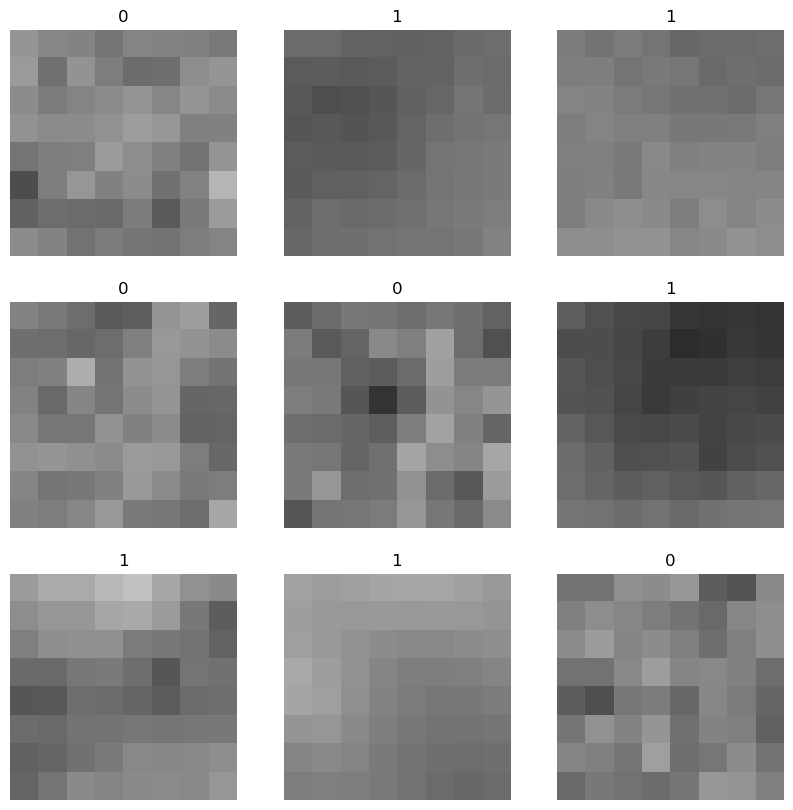

In [71]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


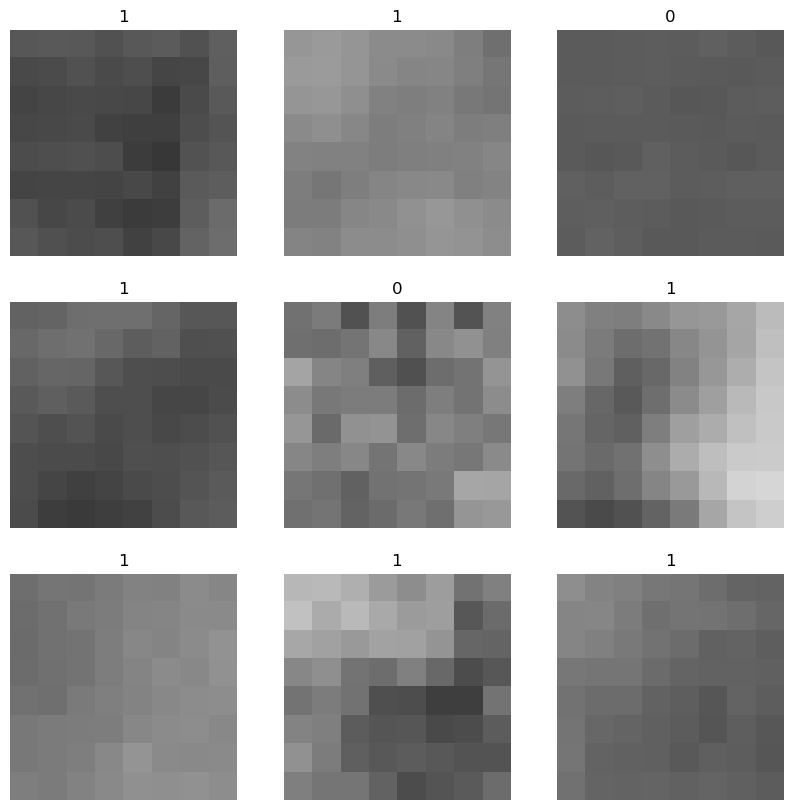

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [73]:
from pathlib import Path #to be able to use functions using path
main_dir = "./img/tiles_" + str(KW) + "x" + str(KH)

from pathlib import Path #to be able to use functions using path

cloudy_dir = Path(main_dir + "/cloudy")
clear_dir = Path(main_dir + "/clear")
cloudy_im = cloudy_dir.glob("*.png")
clear_im = clear_dir.glob("*.png")
train_cloudy_count = 0
train_clear_count = 0
for im in cloudy_im:
    train_cloudy_count += 1
for im in clear_im:
    train_clear_count += 1
    
print(train_cloudy_count)
print(train_clear_count)

80962
72045


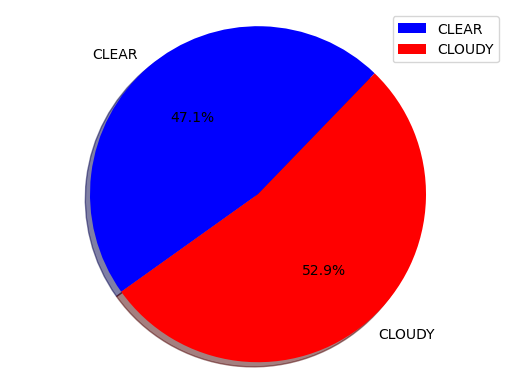

Text(0.5, 1.0, 'Case Distribution')

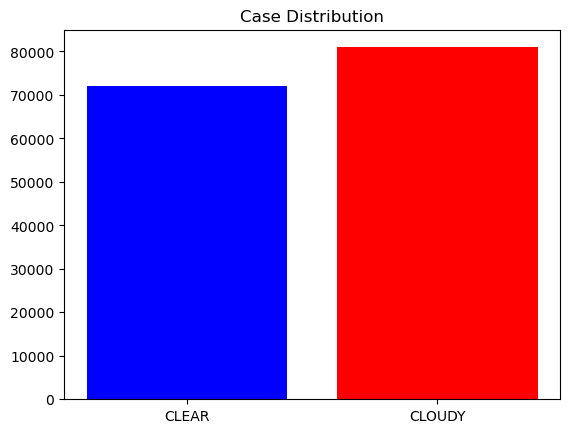

In [74]:
fig1,ax1= plt.subplots()
sizes=[train_clear_count, train_cloudy_count]
ax1.pie(sizes, startangle=46 ,labels=["CLEAR","CLOUDY"], autopct="%1.1f%%", shadow=True, colors=["b","r"])
ax1.axis("equal")
plt.legend()
plt.show()

fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["CLEAR", "CLOUDY"], color=["blue", "red"])
plt.title("Case Distribution")

In [75]:
data_augmentation = keras.Sequential(
    [
#        layers.RandomFlip("horizontal"),
#        layers.RandomRotation(0.1),
    ]
)


In [76]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [77]:
def make_model(input_shape, num_classes):
    MB = KW
#    MB = 32
    inputs = keras.Input(shape=input_shape)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)


    x = layers.Conv2D(8, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16, 64, 256]:
#    for size in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

#    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)


In [78]:
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [79]:

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-6),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 8, 8, 3)]            0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 8, 8, 3)              0         ['input_4[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 4, 4, 8)              224       ['rescaling_3[0][0]']         
                                                                                                  
 batch_normalization_24 (Ba  (None, 4, 4, 8)              32        ['conv2d_12[0][0]']           
 tchNormalization)                                                                          

 ng2D)                                                              ']                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 1, 1, 256)            16640     ['add_10[0][0]']              
                                                                                                  
 add_11 (Add)                (None, 1, 1, 256)            0         ['max_pooling2d_11[0][0]',    
                                                                     'conv2d_15[0][0]']           
                                                                                                  
 separable_conv2d_27 (Separ  (None, 1, 1, 512)            133888    ['add_11[0][0]']              
 ableConv2D)                                                                                      
                                                                                                  
 batch_nor

In [80]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/50
3826/3826 [==============================] - 80s 20ms/step - loss: 0.6293 - accuracy: 0.6385 - val_loss: 0.5217 - val_accuracy: 0.7732
Epoch 2/50
3826/3826 [==============================] - 78s 20ms/step - loss: 0.5030 - accuracy: 0.7721 - val_loss: 0.4470 - val_accuracy: 0.8120
Epoch 3/50
3826/3826 [==============================] - 78s 20ms/step - loss: 0.4485 - accuracy: 0.8012 - val_loss: 0.4072 - val_accuracy: 0.8257
Epoch 4/50
3826/3826 [==============================] - 79s 21ms/step - loss: 0.4163 - accuracy: 0.8153 - val_loss: 0.3802 - val_accuracy: 0.8333
Epoch 5/50
3826/3826 [==============================] - 79s 21ms/step - loss: 0.3937 - accuracy: 0.8241 - val_loss: 0.3601 - val_accuracy: 0.8370
Epoch 6/50
3826/3826 [==============================] - 77s 20ms/step - loss: 0.3753 - accuracy: 0.8318 - val_loss: 0.3429 - val_accuracy: 0.8449
Epoch 7/50
3826/3826 [==============================] - 76s 20ms/step - loss: 0.3595 - accuracy: 0.8411 - val_loss: 0.3276 -

In [ ]:
#save model
model.save('./model/' + bs + '/')

In [125]:
#load a previous model:
model = tf.keras.models.load_model('./model/' + bs + '/')

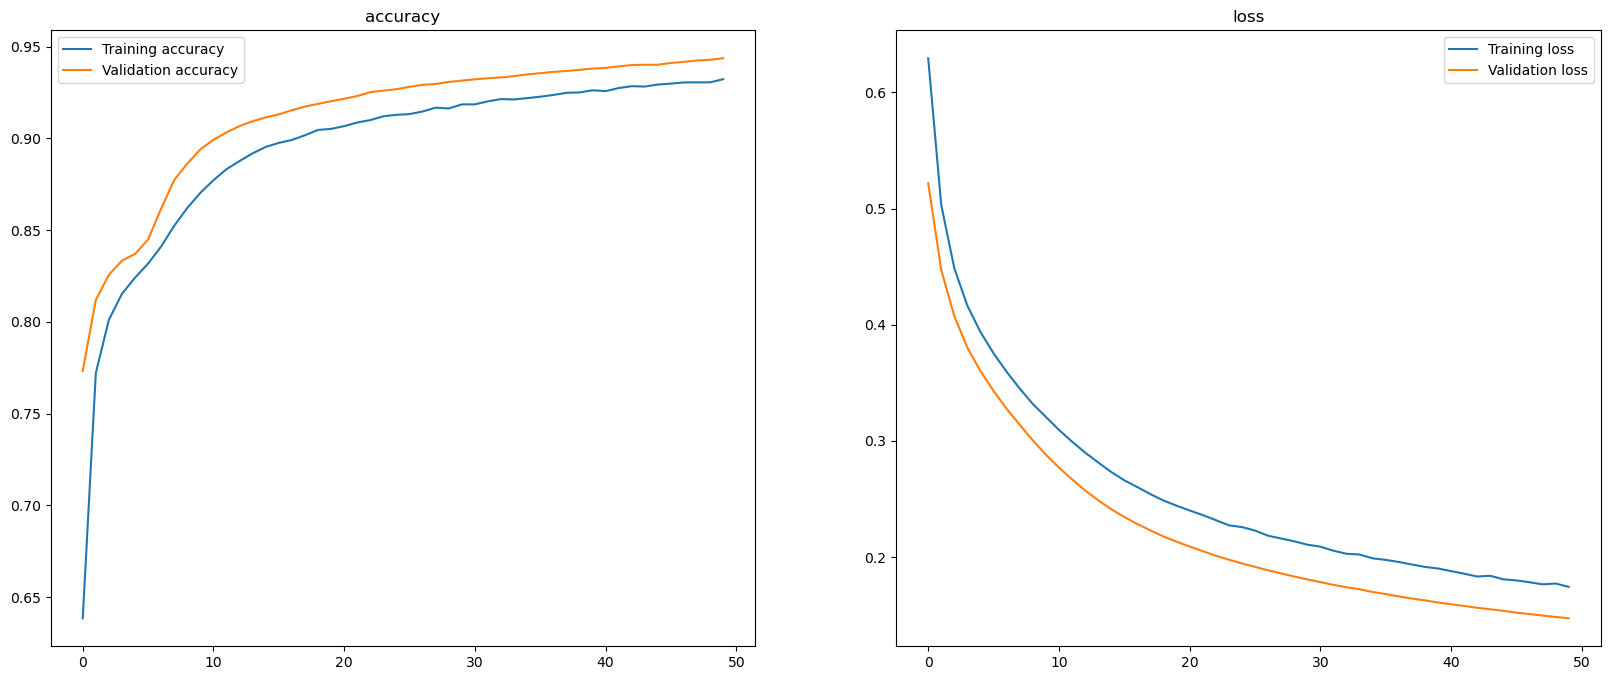

In [126]:
#model performance visualization
f = plt.figure(figsize=(20,8))

#accuracy
plt1 = f.add_subplot(121)
plt1.plot(history.history['accuracy'], label = str('Training accuracy'))
plt1.plot(history.history['val_accuracy'], label = str('Validation accuracy'))
plt.legend()
plt.title('accuracy')

#loss
plt2 = f.add_subplot(122)
plt2.plot(history.history['loss'], label = str('Training loss'))
plt2.plot(history.history['val_loss'], label = str('Validation loss'))
plt.legend()
plt.title('loss')

plt.show()

In [127]:
#save accuracy curve
f = open("./model/" + bs + "/accuracy.txt", "w")
for item in history.history['accuracy']:
    f.write(str(item) + "\n")
f.close()

In [128]:
cmap = plt.colormaps['jet'].copy()
cmap.set_bad('white')      # color of mask on heatmap
cmap.set_under('white')    # color of mask on cbar


In [129]:
IW = 512
IH = 512

size = KW / 2 #side length of kernel from center. 16x16 for size=8
maxSqrSize = 145 #length from center to edge
midx = IW/2
midy = IH/2


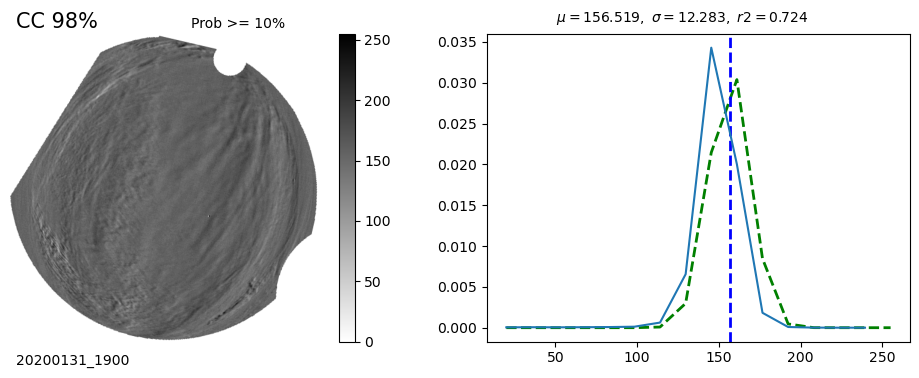

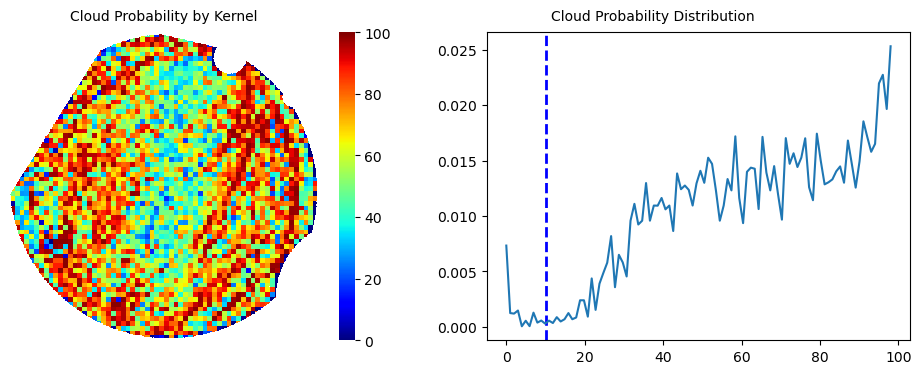

20200131 1900 98


KeyboardInterrupt: 

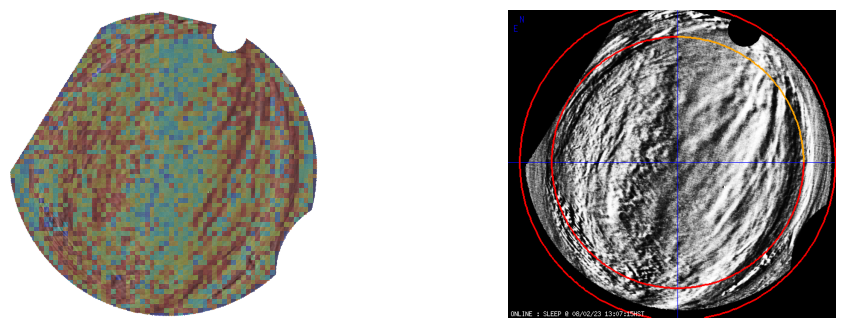

In [130]:
#load image

# make sure to check images from the mix,clear, and cloudy folders
folder="./img/test/20200131/c"

for file in glob.glob(folder + '/*.png'):

# how many tests do you want to look at
#for i in range(1):

#    while True:
#        a=random.choice(os.listdir(folder))
#        if "20200616_2253" in a:
#        if "20200619_2023" in a:
#        if "20230726_2242" in a:
#        if "20230718_0331" in a:
#        if "20230322_2048" in a:
#        if "20220927_0324" in a:
#        if "20220625_2352" in a:
#        if "20220501_0044" in a:
#        if "20220420_2102" in a:
#            break
#    a=random.choice(os.listdir(folder))
#    print (a)
    
#    file = folder+'/'+a
#    print(file)

#im = Image.open("./train/cloudy/202302042354a.png")

    filedate = file.split('/')[3]
    filetime = file.split('_')[1].split('.')[0]

#    print (filedate, filetime)

    im = Image.open(file)

    imc = im
    x_locs = np.arange(size, IW, size * 2)
    y_locs = np.arange(size, IH, size * 2)

    heatmap = np.empty([IH, IW])

    heatmap_masked = []
    
    for y in y_locs:
        for x in x_locs:
            imk = imc.crop((x-size, y-size, x+size, y+size))
            imk.save("tmp.png")
            img = keras.utils.load_img("tmp.png", target_size=image_size)
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        
            predictions = model.predict(img_array, verbose = 0)
            cloudy_score = predictions[0]

            size = int(size)
            y = int(y)
            x = int(x)
            
            for k_y in range(y-size, y+size):
                for k_x in range(x-size, x+size):
                    if (k_y >= IH):
                        continue
                    if (k_x >= IW):
                        continue
                    if (cloudy_score <= 0):
                        heatmap[k_y, k_x] = 0
                    if (cloudy_score >=1):
                        heatmap[k_y, k_x] = 1
                    
                    if (maskdata[k_y, k_x] != 1):
                        heatmap[k_y, k_x] = cloudy_score  
                        heatmap_masked.append(cloudy_score)
                    else:
                        heatmap[k_y, k_x] = 0 # was -1
    
  
    # its 100% not 255 values
    heat = np.uint8(heatmap*100.0)

#calculate percentage cloud coverage. Iterate through image 
#and for a given threshold value set value above to 1 and values below to 0 then average the array

    heatmap_filtered = np.ma.array(heat, mask=maskdata > 0.0)

    imarr = np.array(im)

    data = []
    hdata = []

    th = 0.1
    cloud_count = 0
    total = 0

    for i in range(len(heatmap_filtered)):
        for j in range(len(heatmap_filtered[0])):
            if(maskdata[i, j] < 1):
                total = total + 1
                data.append(imarr[i,j])
                hdata.append(heatmap_filtered[i,j])
                if(heatmap_filtered[i, j] > (th * 100)):
                    cloud_count = cloud_count + 1
    #            else:
    #                print (cloud_count, i,j,heatmap_filtered[i,j])
                    
    #stats
    mu = np.average(data)
    sigma = np.std(data)

    # normalized distribution 
    histogram, bins = np.histogram(data, bins=15, density=True)

    # gaussian
    y = norm.pdf(bins, mu, sigma)

    # truncate last element to match up arrays
    y0 = np.delete(y, -1)

    # fundamental stats
    absError = histogram - y0        
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(y0))    

    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(121)
    
    ia = ax.imshow(im, cmap='gray_r')
    plt.colorbar(ia)

    ax.text(10, -10, 'CC ' + str(int(cloud_count / total * 100)) + '%', fontsize=15)
    ax.text(300, -10, 'Prob >= ' + str(int((th) * 100)) + '%')
    ax.text(10, 550, filedate + '_' + filetime)
    ax.axis('off')
    plt.axis('off')

    ax1 = fig.add_subplot(122)
    ax1.plot(bins, y, 'g', linewidth=2, linestyle='--')
    ax1.axvline(mu, color='b', linewidth=2, linestyle='--')
    ax.text(900,-20, r'$\ \mu=%.3f,\ \sigma=%.3f,\ r2=%.3f$' % (mu, sigma, Rsquared))
    ax1.plot(bins[0:-1], histogram)

    #stats
    mu = np.average(hdata)
    sigma = np.std(hdata)

    # normalized distribution 
    histogram, bins = np.histogram(hdata, bins=100, density=True)

    # gaussian
    y = norm.pdf(bins, mu, sigma)

    # truncate last element to match up arrays
    y0 = np.delete(y, -1)

    # fundamental stats
    absError = histogram - y0        
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(y0))    

    fig.savefig('./img/test/' + filedate + '/r/' + filedate + '_' + filetime + '_0.png')

    fig2 = plt.figure(figsize=(12, 4))

    ax2 = fig2.add_subplot(121)
    ax2.text(100,-20, 'Cloud Probability by Kernel')

    hm = sns.heatmap(heat, cmap=cmap, vmin=0.0, vmax=100.0, cbar=True, annot=False, square=True, mask=maskdata>0.0, alpha=1.0)

    plt.axis('off')
    ax3 = fig2.add_subplot(122)
    ax3.axvline(int(th * 100), color='b', linewidth=2, linestyle='--')
    ax2.text(900,-20, 'Cloud Probability Distribution')
    ax3.plot(bins[0:100:1], histogram)
    
    #save probability values
    f = open("./model/" + bs + "/probabilities.txt", "w")
    for item in hdata:
        f.write(str(item) + "\n")
    f.close()

    plt.show()

    fig2.savefig('./img/test/' + filedate + '/r/' + filedate + '_' + filetime + '_1.png')

    imw = Image.open('./img/test/' + filedate + '/d/' + filedate + '_' + filetime + '_d.png')

    fig3 = plt.figure(figsize=(12, 4))

    fx1 = fig3.add_subplot(121)
    ia = fx1.imshow(im, cmap='gray_r')
    hm = sns.heatmap(heat, cmap=cmap, vmin=0.0, vmax=100.0, cbar=False, annot=False, square=True, mask=maskdata>0.0, alpha=0.25)

    fx1.axis('off')


    fx2 = fig3.add_subplot(122)
    fx2.axis('off')
    fx2.imshow(imw)

    plt.axis('off')

    fig3.savefig('./img/test/' + filedate + '/r/' + filedate + '_' + filetime + '_3.png')

    print (filedate, filetime, int(cloud_count / total * 100))

In [131]:
#ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pred = model.predict(val_ds)
test_labels = np.concatenate([y for x, y in val_ds], axis=0) #print(pred)
#print(val_labels)
fpr, tpr, thresholds = roc_curve(test_labels, pred, pos_label=1)
auc = auc(fpr, tpr)

120/120 [==============================] - 16s 129ms/step


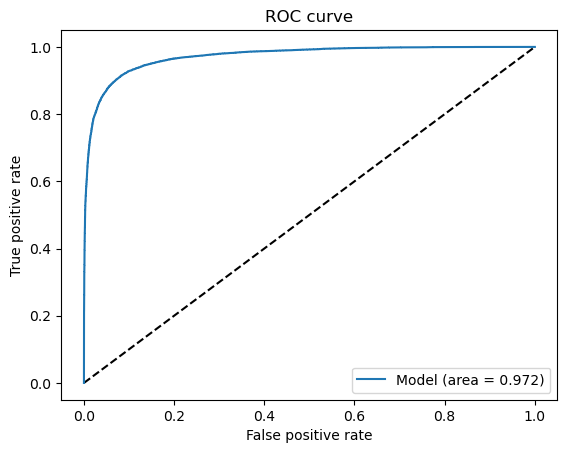

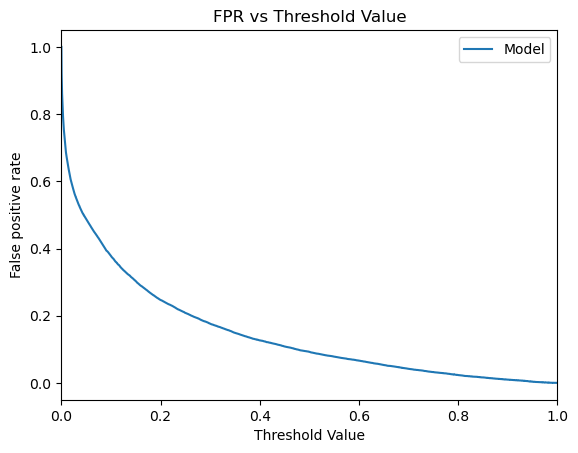

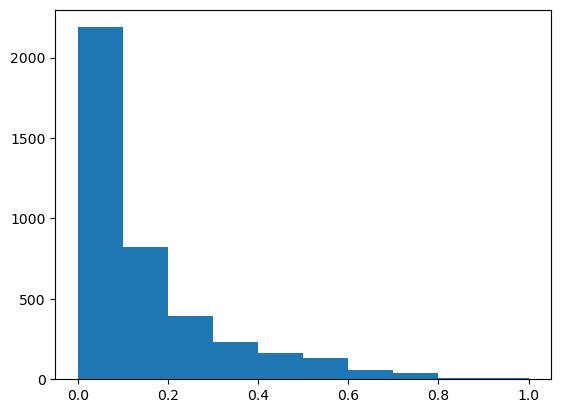

In [132]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.plot(thresholds, fpr, label='Model')
plt.xlabel('Threshold Value')
plt.ylabel('False positive rate')
plt.title('FPR vs Threshold Value')
plt.legend(loc='best')
plt.xlim([0, 1])
plt.show()

plt.figure(3)
counts, bins = np.histogram(fpr)
plt.hist(bins[:-1], bins, weights=counts)
#save ROC data
f = open("./model/" + bs + "/ROC.txt", "w")

for i in range(len(fpr)):
    data = str(fpr[i]) + " " + str(tpr[i]) + " " + str(thresholds[i])
    f.write(str(data) + "\n")
f.close()